In [1]:
import networkx as nx
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Some useful functions

In [2]:
def all_gammas(Xw, Es, adjlist, idx):

    N = int(len(Xw)/2)
    x_gat = np.zeros(len(Xw))
    x_gcn = np.zeros(len(Xw))
    
    for i in range(len(Xw)):
                                 
        psi_function = Es[idx[i]:idx[i] + len(adjlist[i])]
        temp = psi_function - (psi_function).max()
        ex = np.exp(temp)
        gammas_gat = ex / np.sum(ex)             
        x_gat[i] = np.dot(gammas_gat, Xw[adjlist[i]])
        
        gamma_gcn = np.ones(len(adjlist[i]))/len(adjlist[i])
        x_gcn[i] = np.dot(gamma_gcn, Xw[adjlist[i]])
            
    return x_gat, x_gcn

# Create data positive result

In [3]:
n = 400
d = int(np.ceil(n/(np.log(n)**2)))
p = 0.4

sizes = [int(n/2), int(n/2)]

std_ = 0.1
zeta = 0.1
q_lb = (np.log(n)**2)/n

qs = np.linspace(q_lb, 2*p, 30, endpoint=True)

ground_truth = np.concatenate((np.zeros(int(n/2)), np.ones(int(n/2))))

acc_gat = []
acc_gcn = []

acc_gat_std = []
acc_gcn_std = []

trials = 50

for q in qs:
    
    print(q/qs[-1])
    
    acc_gat_list = []
    acc_gcn_list = []
    
    mu = 8*((p+q)/(np.abs(p-q)))*std_*np.sqrt(np.log(n)/max(n*p,n*q))/(2*np.sqrt(d))
    probs = [[p,q], [q,p]]
    
    for trial in range(trials):
        g = nx.stochastic_block_model(sizes, probs)
        n_edges = g.number_of_edges()
        
        nu = 0.1*zeta/(2*np.sqrt(d))

        adjlist = [[v for v in g.neighbors(i)] for i in range(n)]
        tmp = [[ground_truth[v] == ground_truth[i] for v in g.neighbors(i)] for i in range(n)]
        adjlist_labels = []
        for i in range(n):
            adjlist_labels += tmp[i]
        adjlist_labels = np.asarray(adjlist_labels)
        m = len(adjlist_labels)
        idx = np.zeros(n, dtype=int)
        for i in range(n-1):
            idx[i+1] = idx[i] + len(adjlist[i])

        X = np.zeros((n,d))
        X[:int(n/2)] = -mu
        X[int(n/2):] = mu
        noise = std_*np.random.randn(n,d)
        X = X + noise
        
        E = nu*np.ones(m*d)
        E = np.reshape(E, (m,d))*(2*adjlist_labels[:, np.newaxis]-1)
        noise = zeta*np.random.randn(m,d)
        E = E + noise

        R = 1
        mu_ = mu*np.ones(d)
        w = np.sign(p-q)*(R/np.linalg.norm(mu_))*mu_
        Xw = X@w
        
        R = 1
        nu_ = nu*np.ones(d)
        s = np.sign(p-q)*(R/np.linalg.norm(nu_))*nu_
        Es = E@s

        x_gat, x_gcn = all_gammas(Xw, Es, adjlist, idx)  
        
        pred = np.zeros(n)
        pred[x_gat > 0] = 1
        tmp = 1 - np.sum(np.abs(pred - ground_truth))/n
        acc_gat_list.append(tmp)
        
        pred = np.zeros(n)
        pred[x_gcn > 0] = 1
        tmp = 1 - np.sum(np.abs(pred - ground_truth))/n
        acc_gcn_list.append(tmp)
    
    acc_gat.append(np.asarray(acc_gat_list).mean())
    acc_gcn.append(np.asarray(acc_gcn_list).mean())
    
    acc_gat_std.append(np.asarray(acc_gat_list).std())
    acc_gcn_std.append(np.asarray(acc_gcn_list).std())
    

0.11218014818516205
0.14279462583394956
0.17340910348273708
0.2040235811315246
0.23463805878031213
0.26525253642909963
0.2958670140778871
0.3264814917266746
0.3570959693754622
0.38771044702424967
0.4183249246730372
0.4489394023218247
0.4795538799706123
0.5101683576193997
0.5407828352681873
0.5713973129169748
0.6020117905657624
0.6326262682145498
0.6632407458633374
0.6938552235121249
0.7244697011609125
0.7550841788096998
0.7856986564584875
0.8163131341072749
0.8469276117560626
0.8775420894048499
0.9081565670536376
0.938771044702425
0.9693855223512127
1.0


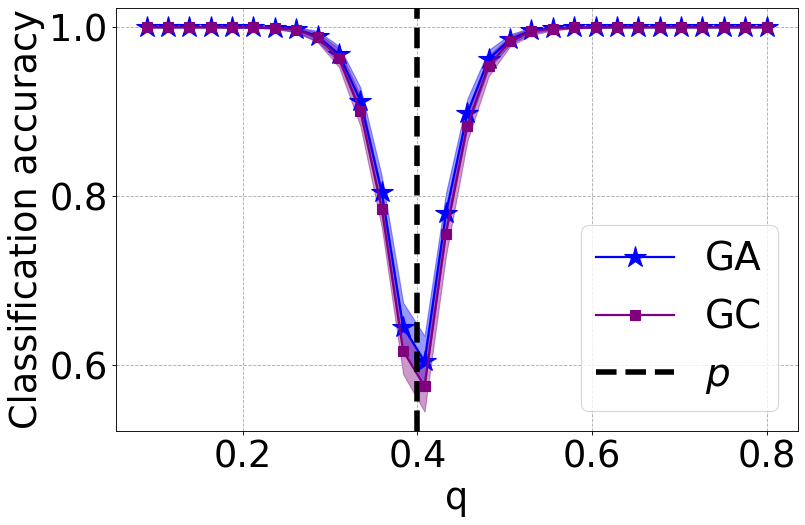

In [4]:
import math

fig = plt.figure(figsize=(11, 7), dpi=80)

plt.plot(qs,acc_gat, linewidth=2, linestyle='-', marker='*', markersize=20,  label='GA', color = 'blue')
plt.fill_between(qs,np.asarray(acc_gat)-np.asarray(acc_gat_std),np.minimum(np.asarray(acc_gat)+np.asarray(acc_gat_std),1),alpha=0.4, color = 'blue')

plt.plot(qs,acc_gcn, linewidth=2, linestyle='-', marker='s', markersize=9,  label='GC', color = 'purple')
plt.fill_between(qs,np.asarray(acc_gcn)-np.asarray(acc_gcn_std),np.minimum(np.asarray(acc_gcn)+np.asarray(acc_gcn_std),1),alpha=0.4, color = 'purple')

plt.axvline(x=p, label="$p$", color="black", linestyle='dashed', linewidth=5)

plt.grid(linestyle='dashed')
plt.legend(fontsize=35, loc='lower right')
plt.xscale('linear')
plt.tick_params(axis='x', labelsize=33)
plt.tick_params(axis='y', labelsize=33)
plt.xlabel('q', fontsize=33)
plt.ylabel('Classification accuracy', fontsize=33)

fig.savefig("figures/noisy_edges_varying_q_positive_result.pdf", dpi=400, bbox_inches='tight')

# Create data negative result

In [5]:
n = 400
d = int(np.ceil(n/(np.log(n)**2)))
p = 0.4

sizes = [int(n/2), int(n/2)]

std_ = 0.1
zeta = 0.1
q_lb = (np.log(n)**2)/n

qs = np.linspace(q_lb, 2*p, 30, endpoint=True)

ground_truth = np.concatenate((np.zeros(int(n/2)), np.ones(int(n/2))))

acc_gat = []
acc_gcn = []

acc_gat_std = []
acc_gcn_std = []

trials = 50

for q in qs:
    
    print(q/qs[-1])
    
    acc_gat_list = []
    acc_gcn_list = []
    
    mu = 0.1*((p+q)/(np.abs(p-q)))*std_*np.sqrt(np.log(n)/max(n*p,n*q))/(2*np.sqrt(d))
    probs = [[p,q], [q,p]]
    
    for trial in range(trials):
        g = nx.stochastic_block_model(sizes, probs)
        n_edges = g.number_of_edges()
        
        nu = 0.1*zeta/(2*np.sqrt(d))

        adjlist = [[v for v in g.neighbors(i)] for i in range(n)]
        tmp = [[ground_truth[v] == ground_truth[i] for v in g.neighbors(i)] for i in range(n)]
        adjlist_labels = []
        for i in range(n):
            adjlist_labels += tmp[i]
        adjlist_labels = np.asarray(adjlist_labels)
        m = len(adjlist_labels)
        idx = np.zeros(n, dtype=int)
        for i in range(n-1):
            idx[i+1] = idx[i] + len(adjlist[i])

        X = np.zeros((n,d))
        X[:int(n/2)] = -mu
        X[int(n/2):] = mu
        noise = std_*np.random.randn(n,d)
        X = X + noise
        
        E = nu*np.ones(m*d)
        E = np.reshape(E, (m,d))*(2*adjlist_labels[:, np.newaxis]-1)
        noise = zeta*np.random.randn(m,d)
        E = E + noise

        R = 1
        mu_ = mu*np.ones(d)
        w = np.sign(p-q)*(R/np.linalg.norm(mu_))*mu_
        Xw = X@w
        
        R = 1
        nu_ = nu*np.ones(d)
        s = np.sign(p-q)*(R/np.linalg.norm(nu_))*nu_
        Es = E@s

        x_gat, x_gcn = all_gammas(Xw, Es, adjlist, idx)  
        
        pred = np.zeros(n)
        pred[x_gat > 0] = 1
        tmp = 1 - np.sum(np.abs(pred - ground_truth))/n
        acc_gat_list.append(tmp)
        
        pred = np.zeros(n)
        pred[x_gcn > 0] = 1
        tmp = 1 - np.sum(np.abs(pred - ground_truth))/n
        acc_gcn_list.append(tmp)
    
    acc_gat.append(np.asarray(acc_gat_list).mean())
    acc_gcn.append(np.asarray(acc_gcn_list).mean())
    
    acc_gat_std.append(np.asarray(acc_gat_list).std())
    acc_gcn_std.append(np.asarray(acc_gcn_list).std())
    

0.11218014818516205
0.14279462583394956
0.17340910348273708
0.2040235811315246
0.23463805878031213
0.26525253642909963
0.2958670140778871
0.3264814917266746
0.3570959693754622
0.38771044702424967
0.4183249246730372
0.4489394023218247
0.4795538799706123
0.5101683576193997
0.5407828352681873
0.5713973129169748
0.6020117905657624
0.6326262682145498
0.6632407458633374
0.6938552235121249
0.7244697011609125
0.7550841788096998
0.7856986564584875
0.8163131341072749
0.8469276117560626
0.8775420894048499
0.9081565670536376
0.938771044702425
0.9693855223512127
1.0


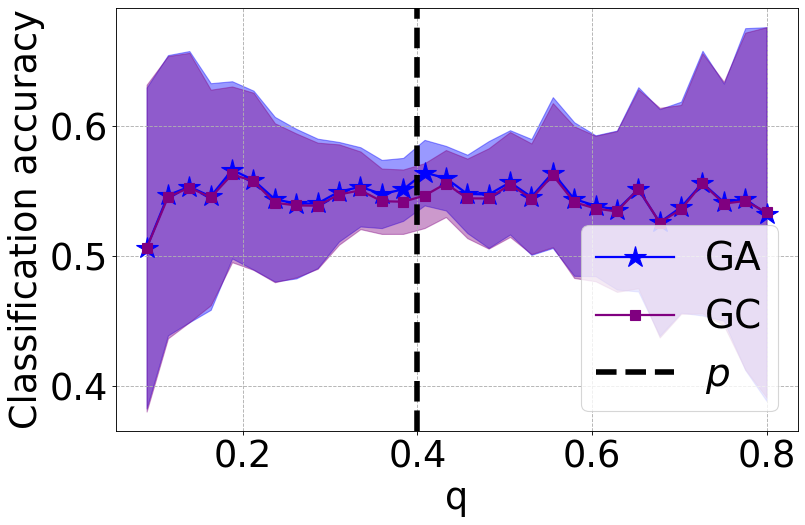

In [6]:
import math

fig = plt.figure(figsize=(11, 7), dpi=80)

plt.plot(qs,acc_gat, linewidth=2, linestyle='-', marker='*', markersize=20,  label='GA', color = 'blue')
plt.fill_between(qs,np.asarray(acc_gat)-np.asarray(acc_gat_std),np.minimum(np.asarray(acc_gat)+np.asarray(acc_gat_std),1),alpha=0.4, color = 'blue')

plt.plot(qs,acc_gcn, linewidth=2, linestyle='-', marker='s', markersize=9,  label='GC', color = 'purple')
plt.fill_between(qs,np.asarray(acc_gcn)-np.asarray(acc_gcn_std),np.minimum(np.asarray(acc_gcn)+np.asarray(acc_gcn_std),1),alpha=0.4, color = 'purple')

plt.axvline(x=p, label="$p$", color="black", linestyle='dashed', linewidth=5)

plt.grid(linestyle='dashed')
plt.legend(fontsize=35, loc='lower right')
plt.xscale('linear')
plt.tick_params(axis='x', labelsize=33)
plt.tick_params(axis='y', labelsize=33)
plt.xlabel('q', fontsize=33)
plt.ylabel('Classification accuracy', fontsize=33)

fig.savefig("figures/noisy_edges_varying_q_negative_result.pdf", dpi=400, bbox_inches='tight')